# Whitening procedure with AutoRegressive (AR) model

*author: Elena Cuoco*

**We can whitening the data in time domain, using the Autoregressive parameters we estimated on a given chunck of data in frame format.**

*Double whitening refers to the procedure applied in the time domain of data whitening, using the inverse of PSD. However, the method used in pytsa is based on the parametric estimation (AR) of the PSD and the Lattice Filter implementation in the time domain.*


In [1]:
import time
import os
import json 
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import Parameters
from wdf.processes.Whitening import Whitening
from wdf.processes.DWhitening import  DWhitening
from pytsa.tsa import FrameIChannel
import logging, sys

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("info")

new_json_config_file = True    # set to True if you want to create new Configuration
if new_json_config_file==True:
    configuration = {
      "file": "./data/test.gwf",
      "channel": "H1:GWOSC-4KHZ_R1_STRAIN", 
      "len":1.0,
      "gps":1167559200,
      "outdir": "./",
      "dir":"./", 
      "ARorder": 1000,
      "learn": 200,
      "preWhite":4
    }

    filejson = os.path.join(os.getcwd(),"parameters.json")
    file_json = open(filejson, "w+")
    json.dump(configuration, file_json)
    file_json.close()
logging.info("read parameters from JSON file")

par = Parameters()
filejson = "parameters.json"
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.sampling))

whiten=Whitening(par.ARorder)  
par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)
par.LVfile ="./LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel)

if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
    logging.info('Load AR parameters')
    whiten.ParametersLoad(par.ARfile, par.LVfile)
    
else:
    logging.info('Start AR parameter estimation')
    ######## read data for AR estimation###############
    strLearn = FrameIChannel(par.file, par.channel, par.learn, par.gps)
    Learn = SV()
    strLearn.GetData(Learn)   
    whiten.ParametersEstimate(Learn)
    whiten.ParametersSave(par.ARfile, par.LVfile)
 
 

INFO:root:read parameters from JSON file
INFO:root:channel= H1:GWOSC-4KHZ_R1_STRAIN at sampling frequency= 4096
INFO:root:Load AR parameters


In [2]:
# sigma for the noise
par.sigma = whiten.GetSigma()
logging.info('Estimated sigma= %s' % par.sigma)

INFO:root:Estimated sigma= 5.09281e-22


We use some chunck of data to pre-heating the whitening procedure and avoiding the filter tail.

In [3]:
#Initialize the loop for the whitening and double whitening
data = SV()
dataw = SV()
dataww =SV()

streaming = FrameIChannel(par.file, par.channel, par.len, par.gps)
streaming.GetData(data)
N=data.GetSize()
   
Dwhiten=DWhitening(whiten.LV,N,0)
if os.path.isfile(par.LVfile):
    logging.info('Load LV parameters')
    Dwhiten.ParametersLoad(par.LVfile)
###---whitening preheating---###
for i in range(par.preWhite):
    streaming.GetData(data)
    whiten.Process(data, dataw)
    Dwhiten.Process(data, dataww)
    

INFO:root:Load LV parameters


In [4]:
# data to be plotted 
streaming.GetData(data)
whiten.Process(data, dataw)
Dwhiten.Process(data, dataww)

## Plot: raw, whitened and double-whitened data

### Time-domain

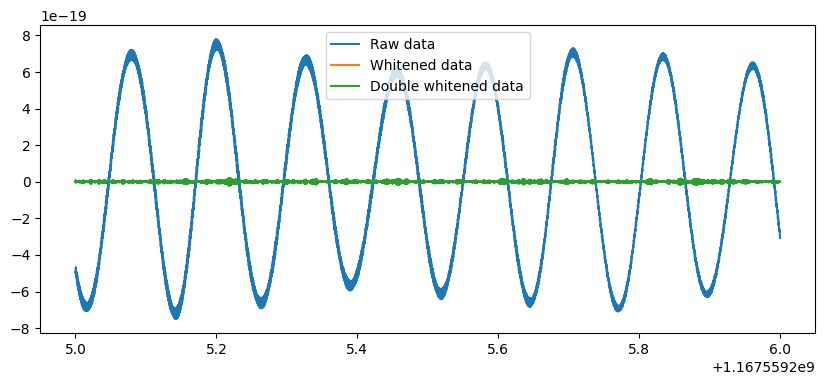

In [5]:
import numpy as np
 
import matplotlib
import matplotlib.pyplot as plt
 
%matplotlib inline 
 
plt.rcParams['figure.figsize'] = (15.0, 10.0)
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

x=np.zeros(data.GetSize())
y=np.zeros(data.GetSize())
yw=np.zeros(data.GetSize())
yww=np.zeros(data.GetSize())

for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    y[i]=data.GetY(0,i)
    yw[i]=dataw.GetY(0,i)
    yww[i]=dataww.GetY(0,i)

plt.figure(figsize=(10,4))
plt.plot(x, y,  label='Raw data')
plt.plot(x, yw, label='Whitened data')
plt.plot(x, yww, label='Double whitened data')

plt.legend()
plt.show()
    


### Frequency domain (PSD)

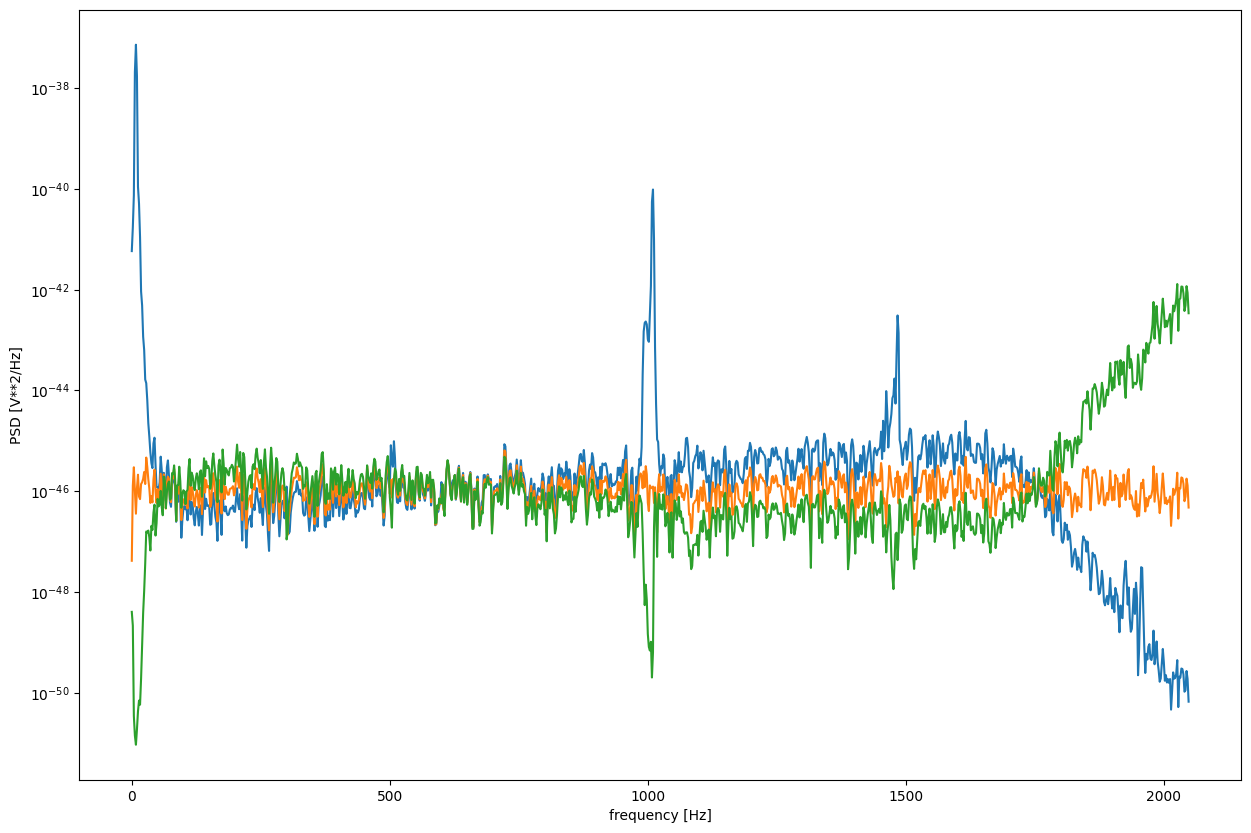

In [6]:
from scipy import signal
f, Pxx_den = signal.welch(y, par.sampling, nperseg=2048)
f, Pxx_denW = signal.welch(yw, par.sampling, nperseg=2048)
f, Pxx_denWW = signal.welch(yww, par.sampling, nperseg=2048)
fig, ax = plt.subplots()
ax.semilogy(f, Pxx_den)
ax.semilogy(f, Pxx_denW) 
ax.semilogy(f, Pxx_denWW) 
 
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### Time-Frequency domain

<Figure size 1000x400 with 0 Axes>

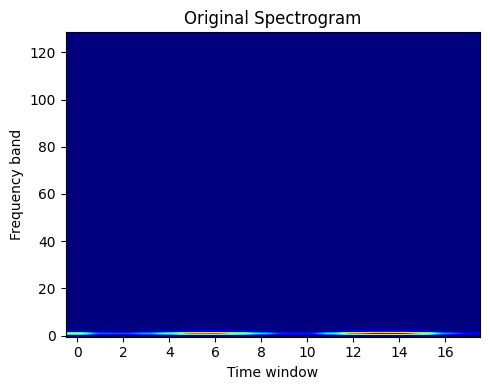

In [7]:
plt.figure(figsize=(10,4)),  
freqs, times, spectrogram = signal.spectrogram(y)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title('Original Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

<Figure size 1000x400 with 0 Axes>

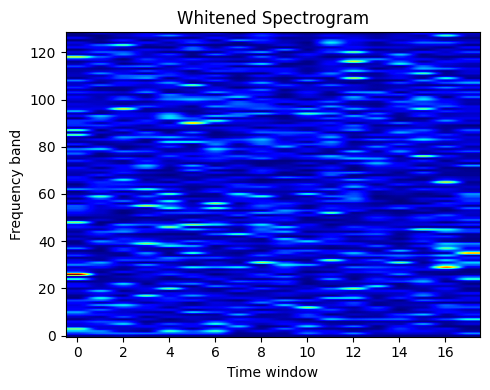

In [8]:
plt.figure(figsize=(10,4)),  
freqs, times, spectrogram = signal.spectrogram(yw)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title('Whitened Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

<Figure size 1000x400 with 0 Axes>

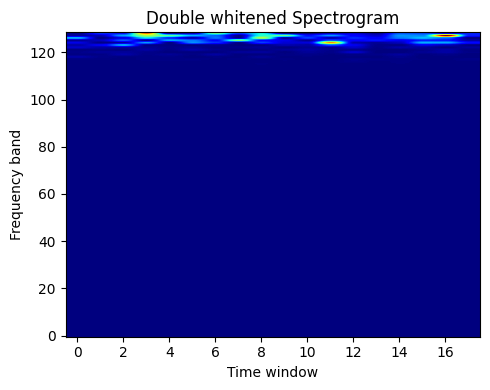

In [9]:
plt.figure(figsize=(10,4)), 
freqs, times, spectrogram = signal.spectrogram(yww)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title('Double whitened Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()